In [4]:
import numpy as np
import matplotlib.pyplot as plt
from beam_mechanics_3_script import simulate_beam, m_line_of_s
from constants import *

A reference trajectory is created in the form of a sine wave

In [5]:
def con_ref(theta_ref):
    return (theta_ref,0)


def sine_reference(Amp, freq, offset_rad = 0.0, phase_rad=0.0):
    w = 2*np.pi*freq
    return lambda t: (offset_rad + Amp*np.sin(w*t+phase_rad), Amp*w*np.cos(w*t+phase_rad))


Here we build the reference trajectory which the controller will follow

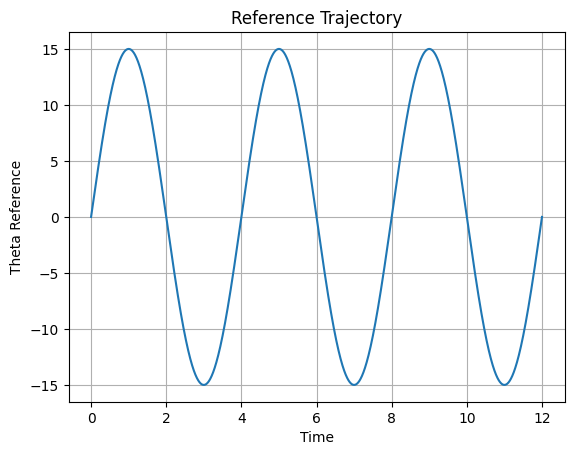

In [6]:
T = 12
dt = 0.005
amplitude = 15
frequency = 0.25
offset = 0.0
phase_shift = 0.0
time = np.arange(0,T+dt,dt)
theta_ref_mk = sine_reference(amplitude, frequency, offset, phase_shift)
theta_ref_values = []
for ti in time:
    theta_ref_values.append(theta_ref_mk(ti)[0])

theta_ref = np.array(theta_ref_values)
plt.figure()
plt.plot(time, theta_ref)
plt.xlabel("Time")
plt.ylabel("Theta Reference")
plt.title("Reference Trajectory")
plt.grid()
plt.show()
    



We will now implement a basic PD controller. We add a parameter to smooth the derivative also.

In [ ]:
def pd_controller(p_vec, ref_traj, time, dt, gain, kp, kd):
    t_hist, u_hist, err_hist, delt_u_hist, theta_hist, ref_hist = [], [], [], [], [], []
    psi_rad = 0
    psi_up = 0
    d_error = 0
    prev_error = 0
    N = int(time/dt)
    for k in range(N):
        t = k*dt
        
        theta_real,_,_,_ = simulate_beam(
                p_vec, psi_rad,
                L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
                MU0=MU0, MAGNET_M=MAGNET_M,
                m_line_of_s=m_line_of_s,
                s_steps=200
            )
        error_pd = ref_traj - theta_real
        d_error = (error_pd - prev_error)/dt
        prev_error = error_pd

        delta_psi = gain*(kp * error_pd + kd * d_error)
        psi_up = psi_up + delta_psi

        t_hist.append(t)
        u_hist.append(psi_up)
        err_hist.append(error_pd)
        delt_u_hist.append(delta_psi)
        theta_hist.append(theta_real)
        ref_hist.append(ref_traj)
    return dict(
        t = np.array(t_hist),
        theta_rad = np.array(theta_hist),
        theta_ref = np.array(ref_hist),
        psi_rad = np.array(u_hist),
        error_rad = np.array(err_hist),
        u_up = np.array(delt_u_hist),
    )


In [ ]:
p_vec = np.array([0,0.19,0])
time = 12
dt = 0.01
gain = 1
kp = 1.5
kd = 0.05
ref_traj = con_ref(np.rad2deg(15))[0]
test_pd_control = pd_controller(p_vec, ref_traj, time, dt, gain, kp, kd)

We add the integral term into the controller 

In [ ]:
def pid_controller(p_vec, ref_traj, time, dt, gain, kp, kd, ki):
    t_hist, u_hist, err_hist, delt_u_hist, theta_hist, ref_hist = [], [], [], [], [], []
    psi_rad = 0
    psi_up = 0
    d_error = 0
    e_int = 0
    prev_error = 0
    N = int(time/dt)
    for k in range(N):
        t = k*dt
        
        theta_real,_,_,_ = simulate_beam(
                p_vec, psi_rad,
                L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
                MU0=MU0, MAGNET_M=MAGNET_M,
                m_line_of_s=m_line_of_s,
                s_steps=200
            )
        error_pd = ref_traj - theta_real
        d_error = (error_pd - prev_error)/dt
        prev_error = error_pd
        e_int += e_int*dt

        delta_psi = gain*(kp * error_pd + ki*e_int + kd * d_error)
        psi_up = psi_up + delta_psi

        t_hist.append(t)
        u_hist.append(psi_up)
        err_hist.append(error_pd)
        delt_u_hist.append(delta_psi)
        theta_hist.append(theta_real)
        ref_hist.append(ref_traj)
    return dict(
        t = np.array(t_hist),
        theta_rad = np.array(theta_hist),
        theta_ref = np.array(ref_hist),
        psi_rad = np.array(u_hist),
        error_rad = np.array(err_hist),
        u_up = np.array(delt_u_hist),
    )
